In [1]:
import pickle
import pandas as pd
import numpy as np
import torch
import transformers
import bitsandbytes as bnb
import networkx as nx

random_state = 1

In [2]:
def euclid(list1, list2):
    return sum((p-q)**2 for p, q in zip(list1, list2)) ** .5

In [3]:
with open('df_annotations_embeddings.pkl', 'rb') as f:
    df = pickle.load(f)
df

,Document,Split,Name,Id,Text,Type,Scheme,embeddings
0,A2008_Commission of the European Communities v...,1,prem,A1,must held first Article 4c CS prohibits granti...,L,Rule,"[-0.01507568359375, -1.73828125, 1.4287109375,..."
1,A2008_Commission of the European Communities v...,1,prem,A2,Also clear consistent caselaw Articles 4 CS 67...,L,"[Itpr, Prec, Rule]","[0.93017578125, -1.0146484375, 0.0575256347656..."
2,A2008_Commission of the European Communities v...,1,prem,A3,Court deduces Article 67 CS covers general mea...,L,"[Prec, Rule]","[0.195556640625, -1.734375, -0.1546630859375, ..."
3,A2008_Commission of the European Communities v...,1,prem,A4,Court also held action taken Article 67 CS can...,L,"[Prec, Rule]","[0.404296875, -0.2352294921875, 0.34326171875,..."
4,A2008_Commission of the European Communities v...,1,prem,A5,Court held particular inconceivable authors EC...,L,"[Itpr, Prec, Rule]","[1.0849609375, -0.98828125, 0.39453125, 0.8774..."
...,...,...,...,...,...,...,...,...
2530,R2021_World Duty Free v,5,prem,H7,question matter dialogue Spanish authorities C...,F,NaN,"[2.109375, -1.3642578125, -0.62744140625, 2.50..."
2531,R2021_World Duty Free v,5,prem,H8,present case action first instance WDFG compla...,F,NaN,"[0.880859375, -0.65966796875, -0.67626953125, ..."
2532,R2021_World Duty Free v,5,prem,H9,regard General Court recalled paragraph 212 ju...,F,NaN,"[2.0234375, -1.150390625, -0.70947265625, 1.59..."
2533,R2021_World Duty Free v,5,prem,H10,General Court err law concluding therefrom par...,F,NaN,"[1.6494140625, -1.5732421875, -0.857421875, 1...."


In [4]:
df_train = df[df['Split'] != 5]
df_train = df_train.dropna(subset = ['Type'])
df_train

,Document,Split,Name,Id,Text,Type,Scheme,embeddings
0,A2008_Commission of the European Communities v...,1,prem,A1,must held first Article 4c CS prohibits granti...,L,Rule,"[-0.01507568359375, -1.73828125, 1.4287109375,..."
1,A2008_Commission of the European Communities v...,1,prem,A2,Also clear consistent caselaw Articles 4 CS 67...,L,"[Itpr, Prec, Rule]","[0.93017578125, -1.0146484375, 0.0575256347656..."
2,A2008_Commission of the European Communities v...,1,prem,A3,Court deduces Article 67 CS covers general mea...,L,"[Prec, Rule]","[0.195556640625, -1.734375, -0.1546630859375, ..."
3,A2008_Commission of the European Communities v...,1,prem,A4,Court also held action taken Article 67 CS can...,L,"[Prec, Rule]","[0.404296875, -0.2352294921875, 0.34326171875,..."
4,A2008_Commission of the European Communities v...,1,prem,A5,Court held particular inconceivable authors EC...,L,"[Itpr, Prec, Rule]","[1.0849609375, -0.98828125, 0.39453125, 0.8774..."
...,...,...,...,...,...,...,...,...
2179,R2017_Viasat Broadcasting UK Ltd v European Co...,3,prem,C5,Viasat conceded contested decision would vitia...,L,"[Itpr, Rule]","[0.95947265625, -0.26904296875, 0.108215332031..."
2180,R2017_Viasat Broadcasting UK Ltd v European Co...,3,prem,C6,However follows paragraph 37 Article 1062 TFEU...,L,"[Itpr, Prec, Rule]","[0.53271484375, -0.84521484375, 1.265625, 0.18..."
2181,R2017_Viasat Broadcasting UK Ltd v European Co...,3,prem,C7,Accordingly General Court err law holding suff...,F,NaN,"[0.876953125, -0.80712890625, -0.64599609375, ..."
2182,R2017_Viasat Broadcasting UK Ltd v European Co...,3,prem,C8,Moreover Advocate General observed point 58 Op...,F,Aut,"[-0.1265869140625, -1.0302734375, -0.494384765..."


In [5]:
df_test = df[df['Split'] == 5]
df_test = df_test.dropna(subset = ['Type'])
df_test

,Document,Split,Name,Id,Text,Type,Scheme,embeddings
612,A2017_European Commission v TV2_Danmark A_S,5,prem,A1,accordance Court’s settled caselaw classificat...,L,"[Class, Prec, Rule]","[0.7919921875, -1.1328125, -0.8232421875, 0.68..."
613,A2017_European Commission v TV2_Danmark A_S,5,prem,A2,provision sets four conditions,L,Class,"[0.60986328125, -0.7099609375, 0.8125, 1.06640..."
614,A2017_European Commission v TV2_Danmark A_S,5,prem,A2bis,First must intervention State State resources,L,Class,"[1.8837890625, -1.041015625, -0.82080078125, 2..."
615,A2017_European Commission v TV2_Danmark A_S,5,prem,A2ter,Second intervention must liable affect trade M...,L,Class,"[1.5693359375, -1.37890625, -0.32177734375, 2...."
616,A2017_European Commission v TV2_Danmark A_S,5,prem,A2quater,Third must confer advantage recipient,L,Class,"[1.859375, -0.51611328125, -1.455078125, 2.179..."
...,...,...,...,...,...,...,...,...
2529,R2021_World Duty Free v,5,prem,H6bis,hand General Court rightly pointed paragraph 2...,L,Itpr,"[1.4169921875, -1.34765625, -0.240234375, 1.42..."
2530,R2021_World Duty Free v,5,prem,H7,question matter dialogue Spanish authorities C...,F,NaN,"[2.109375, -1.3642578125, -0.62744140625, 2.50..."
2531,R2021_World Duty Free v,5,prem,H8,present case action first instance WDFG compla...,F,NaN,"[0.880859375, -0.65966796875, -0.67626953125, ..."
2532,R2021_World Duty Free v,5,prem,H9,regard General Court recalled paragraph 212 ju...,F,NaN,"[2.0234375, -1.150390625, -0.70947265625, 1.59..."


In [ ]:
distances = []
for j in range(len(df_train)):
    newlist = []
    for i in range(len(df_train)):
        newlist.append(euclid(df_train.iloc[j]['embeddings'], df_train.iloc[i]['embeddings']))
    distances.append(newlist)
    print(j)

0
1
2
3
4
5
6
7
8


In [27]:
closenodes = []
for el in distances:
    count = 0
    for newel in el:
        if newel <= 33.33:# * 0.78:      #set manually, 41.40 yields on average (N/15)**0.5 nodes, 33.33 yields on avg 15 nodes
            count += 1
    closenodes.append(count)

print(sum(closenodes)/len(closenodes))  #average size of extracted subgraph
print(min(closenodes))                  #min degree
print(max(closenodes))                  #max degree

16.030939871570343
1
171


In [28]:
Training_graph = nx.Graph() #Resoluti

for i in range(len(df_train)):
    print('adding node',i)
    Training_graph.add_node(i)
    for j in range(i):
        if euclid(df_train.iloc[j]['embeddings'], df_train.iloc[i]['embeddings']) <= 33.33:      #così in media ogni nodo è collegato ad altri 15
            Training_graph.add_edge(i,j)

adding node 0
adding node 1
adding node 2
adding node 3
adding node 4
adding node 5
adding node 6
adding node 7
adding node 8
adding node 9
adding node 10
adding node 11
adding node 12
adding node 13
adding node 14
adding node 15
adding node 16
adding node 17
adding node 18
adding node 19
adding node 20
adding node 21
adding node 22
adding node 23
adding node 24
adding node 25
adding node 26
adding node 27
adding node 28
adding node 29
adding node 30
adding node 31
adding node 32
adding node 33
adding node 34
adding node 35
adding node 36
adding node 37
adding node 38
adding node 39
adding node 40
adding node 41
adding node 42
adding node 43
adding node 44
adding node 45
adding node 46
adding node 47
adding node 48
adding node 49
adding node 50
adding node 51
adding node 52
adding node 53
adding node 54
adding node 55
adding node 56
adding node 57
adding node 58
adding node 59
adding node 60
adding node 61
adding node 62
adding node 63
adding node 64
adding node 65
adding node 66
addin

In [29]:
pickle.dump(Training_graph, open('R15_task2.pickle', 'wb'))


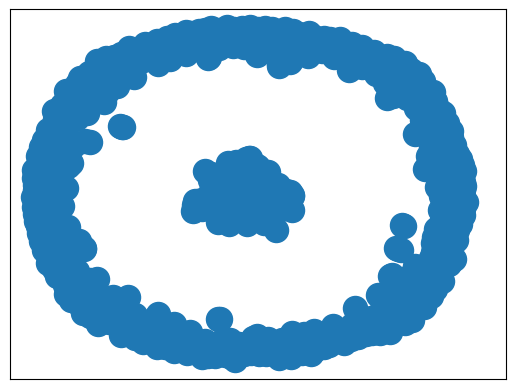

In [30]:
nx.draw_networkx(Training_graph, with_labels = False)

In [31]:
len(Training_graph)

1713